In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/modeling_dataset.csv')
df_2023 = pd.read_csv('../data/dataset_2023.csv')

In [3]:
df.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,WS/48,OBPM,DBPM,BPM,VORP,Salary,Cap Maximum,Years Experience Category,Draft Position Category,Total Minutes
0,Arron Afflalo,SG,24,DEN,82,75,27.1,3.3,7.1,0.465,...,0.092,-0.2,-0.2,-0.4,0.9,1086240.0,57700000,1-4,21-30,2222.2
1,Alexis Ajinça,C,21,CHA,6,0,5.0,0.8,1.7,0.500,...,-0.013,-6.3,1.0,-5.3,0.0,1372080.0,57700000,1-4,11-20,30.0
2,LaMarcus Aldridge,PF,24,POR,78,78,37.5,7.4,15.0,0.495,...,0.145,1.4,-0.2,1.2,2.3,5844827.0,57700000,1-4,1-4,2925.0
3,Joe Alexander,SF,23,CHI,8,0,3.6,0.1,0.8,0.167,...,0.030,-9.1,0.9,-8.3,0.0,2583360.0,57700000,1-4,5-10,28.8
4,Malik Allen,PF,31,DEN,51,3,8.9,0.9,2.3,0.397,...,0.009,-4.7,-1.0,-5.7,-0.4,1300000.0,57700000,1-4,undrafted,453.9


In [4]:
df.set_index('Player',inplace = True)
df_2023.set_index('Player',inplace = True)

### Train Test Split

In [5]:
X=df.drop(columns = ['Tm','Salary'])

In [6]:
y= df['Salary']

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42)

### Transforming Columns

In [8]:
columns = X.columns.to_list()
categories = ['Years Experience Category','Draft Position Category','Pos']
ints = columns
for i in categories:
    ints.remove(i)

In [9]:
ctx = ColumnTransformer(
    transformers = [
        ('ohe',OneHotEncoder(drop = 'if_binary',handle_unknown= 'ignore',sparse_output = False), categories),
        ('sc',StandardScaler(),ints)
    ])

In [10]:
X_train_ohe_scaled = ctx.fit_transform(X_train)

In [11]:
X_test_ohe_scaled = ctx.transform(X_test)

### Modeling
From EDA, it seems that a lot of features have a non linear relationship. I expect a random forest regressor or a gradient boosting algorithm to perform better!

### Random Forest

In [12]:
rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train_ohe_scaled,y_train)

RandomForestRegressor(random_state=42)

In [13]:
print(f'Training R^2: {rf.score(X_train_ohe_scaled,y_train)}')
print(f'Testing R^2: {rf.score(X_test_ohe_scaled,y_test)}')
rf_preds= rf.predict(X_test_ohe_scaled)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,rf_preds))}')

Training R^2: 0.9640608943999148
Testing R^2: 0.7606337530120255
RMSE: 3373558.7446322786


Random Forest is performing pretty well

### Gradient Boosting

In [14]:
gb= GradientBoostingRegressor(random_state = 42)
gb.fit(X_train_ohe_scaled,y_train)

GradientBoostingRegressor(random_state=42)

In [15]:
print(f'Training R^2: {gb.score(X_train_ohe_scaled,y_train)}')
print(f'Testing R^2: {gb.score(X_test_ohe_scaled,y_test)}')
gb_preds= gb.predict(X_test_ohe_scaled)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,gb_preds))}')

Training R^2: 0.8126429740072632
Testing R^2: 0.7614388601468314
RMSE: 3367880.492215172


### GridSearched Random Forest

In [37]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_ohe_scaled, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 400}

In [74]:
print(f'Training R^2: {grid_search.score(X_train_ohe_scaled,y_train)}')
print(f'Testing R^2: {grid_search.score(X_test_ohe_scaled,y_test)}')
grid_search_preds= grid_search.predict(X_test_ohe_scaled)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,grid_search_preds))}')

Training R^2: 0.9526074228292496
Testing R^2: 0.7608249786415091
RMSE: 3372210.935999719


### Stacked Model

In [34]:
estimators = [('gradient boosting',gb),
             ('random forest',rf),]
stacked_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

In [35]:
stacked_model.fit(X_train_ohe_scaled,y_train)

StackingRegressor(estimators=[('gradient boosting',
                               GradientBoostingRegressor(random_state=42)),
                              ('random forest',
                               RandomForestRegressor(random_state=42))],
                  final_estimator=LinearRegression())

In [36]:
print(f'Training R^2: {stacked_model.score(X_train_ohe_scaled,y_train)}')
print(f'Testing R^2: {stacked_model.score(X_test_ohe_scaled,y_test)}')
stacked_model_preds= stacked_model.predict(X_test_ohe_scaled)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,stacked_model_preds))}')

Training R^2: 0.9135759610788843
Testing R^2: 0.7729092768966879
RMSE: 3285916.4635113445


### Model Evaluation, Inference
The stacked model had the best metrics, but it is impossible to see the top coefficients from this model. To approximate this- I will take the feature importances of both and combine them, then divide by 2.

In [37]:
rf_importance_dict = dict(zip(ctx.get_feature_names_out(), rf.feature_importances_))

In [38]:
gb_importance_dict = dict(zip(ctx.get_feature_names_out(),gb.feature_importances_))

In [39]:
average_importance_dict = {}
for key in rf_importance_dict.keys():
    average_importance = (rf_importance_dict[key] + gb_importance_dict[key]) / 2
    average_importance_dict[key] = average_importance


In [40]:
average_importance_df = pd.DataFrame(list(average_importance_dict.items()), columns=['Feature', 'Average Feature Importance'])
average_importance_df['Average Feature Importance'].sum()

1.0

In [41]:
average_importance_df.sort_values('Average Feature Importance', inplace = True)
top_5 = average_importance_df.tail()
average_importance_df.sort_values('Average Feature Importance',ascending = True,inplace = True)
bottom_5 = average_importance_df.head()

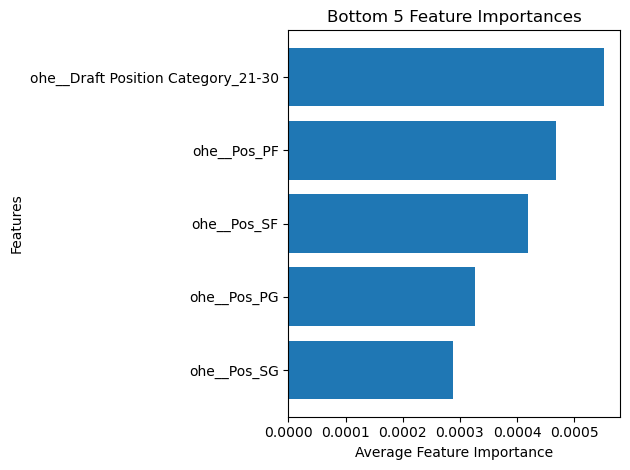

In [42]:
plt.barh(bottom_5['Feature'], bottom_5['Average Feature Importance'])
plt.xlabel('Average Feature Importance')
plt.ylabel('Features')
plt.title('Bottom 5 Feature Importances')
plt.tight_layout()
plt.savefig('../figures/bottom_5_features.png')

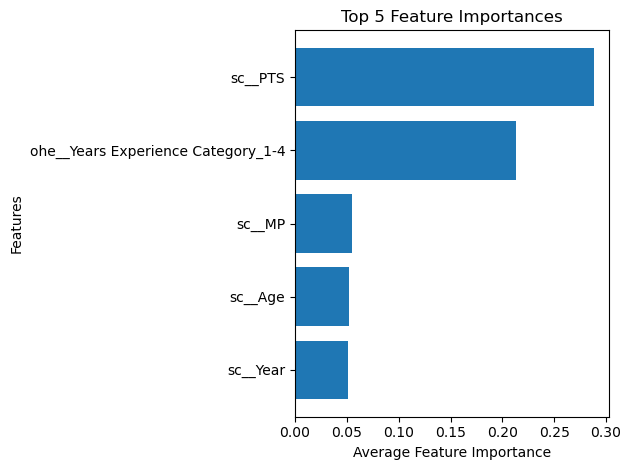

In [43]:
plt.barh(top_5['Feature'], top_5['Average Feature Importance'])
plt.xlabel('Average Feature Importance')
plt.ylabel('Features')
plt.title('Top 5 Feature Importances')
plt.tight_layout()
plt.savefig('../figures/top_5_features.png')

### Predictions
The Stacked model had the best RMSE and the best testing R^2 so that is what i will use for predictions! 

In [44]:
X_p = df_2023.drop(columns = ['Tm','Salary'])
y_p = df_2023['Salary']

In [45]:
X_p_ohe_scaled = ctx.transform(X_p)
predictions = pd.DataFrame(y_p)

In [46]:
predictions = pd.DataFrame(y_p)
predictions['Predicted Salary']= stacked_model.predict(X_p_ohe_scaled)
predictions.rename(columns = {'Salary':'True Salary'}, inplace = True)
predictions['Disparity']= predictions['Predicted Salary']-predictions['True Salary']
predictions['Disparity Percentage'] =(predictions['Disparity'] / predictions['True Salary']) * 100

In [47]:
predictions.sort_values('Disparity',inplace=True)
bottom_5_disparity = predictions.head()
top_5_disparity =predictions.tail()

In [48]:
top_5_disparity

,True Salary,Predicted Salary,Disparity,Disparity Percentage
Player,,,,
Jordan Clarkson,13340000.0,2.489880e+07,1.155880e+07,86.647702
Dennis Schröder,1836090.0,1.361196e+07,1.177587e+07,641.356025
Kyle Kuzma,13000000.0,2.498695e+07,1.198695e+07,92.207321
Kris Dunn,735819.0,1.321784e+07,1.248202e+07,1696.344258
Shaquille Harrison,0.0,1.256111e+07,1.256111e+07,inf


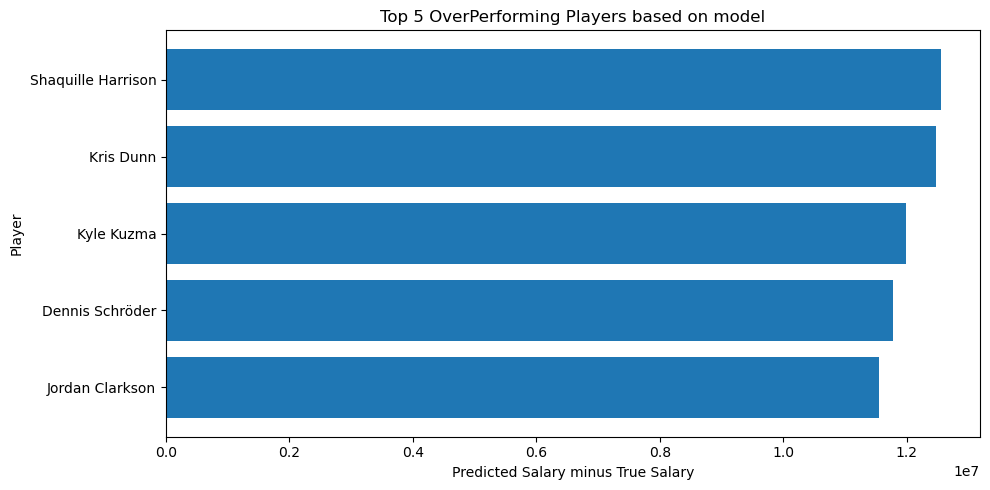

In [49]:
plt.figure(figsize=(10, 5))
plt.barh(top_5_disparity.index, top_5_disparity['Disparity'])
plt.xlabel('Predicted Salary minus True Salary')
plt.ylabel('Player')
plt.title('Top 5 OverPerforming Players based on model')
plt.tight_layout()
plt.savefig('../figures/5_overperforming')

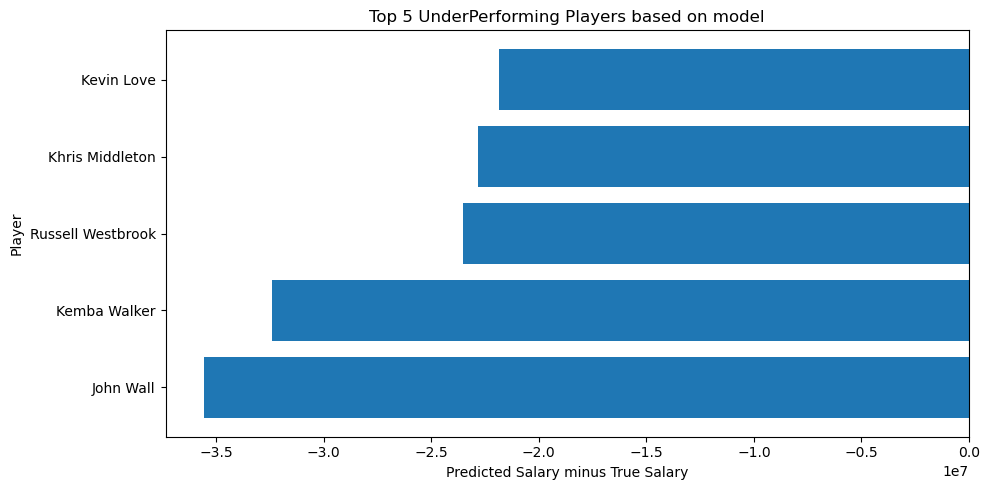

In [50]:
plt.figure(figsize=(10, 5))
plt.barh(bottom_5_disparity.index, bottom_5_disparity['Disparity'])
plt.xlabel('Predicted Salary minus True Salary')
plt.ylabel('Player')
plt.title('Top 5 UnderPerforming Players based on model')
plt.tight_layout()
plt.savefig('../figures/5_underperforming')

### More Model Evaluation

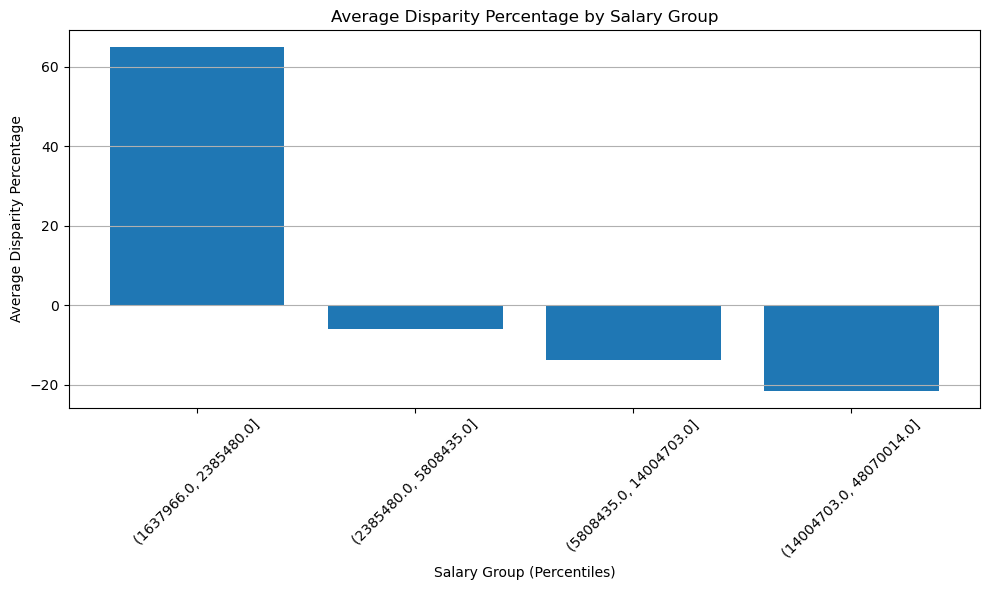

In [51]:
predictions['Salary Group'] = pd.qcut(predictions['True Salary'], 5)
average_disparity = predictions.groupby('Salary Group')['Disparity Percentage'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.bar(average_disparity['Salary Group'].astype(str), average_disparity['Disparity Percentage'])
plt.xlabel('Salary Group (Percentiles)')
plt.ylabel('Average Disparity Percentage')
plt.title('Average Disparity Percentage by Salary Group')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('../figures/average_disparity_percentage_by_salary_group.png')


The model is overpredicting lower salaries and underpredicting higher salaries.

In [52]:
predictions.to_csv('../data/predicted_2023.csv')

### Conclusion

This stacked model can be used to evaluate player performance in a given season based on whether they underperformed or outperformed their salary. The model had an r^2 score of 77%. In addition, it can be used by general managers and player agents as a tool in negotiations. The model is biased towards overpredicting lower salaries and underpredicting higher salaries. This is either a limitation of the model, or a misuse of financial resources across the NBA.

### Areas for Improvement

- More stats could be added, like per 36 minutes stats.
- Could cross validate salary data with another source.
- Streamlit app could have more functionality
- Experimentation with neural networks
- Incorporating playoff stats